## Plot composite reflectivity + HALO circle + HALO dropsonde data

- composite reflectivity from SEA-POL /huracan/tank4/cornell/ORCESTRA/sea-pol/qc_data/level4b/PICCOLO_level4b_composite_2D.nc
- HALO flight segmentation data: ipfs://QmSpviiAWcdFTRJu7UPkJePoEkK1XWZefx7ZjS5zuHNiFA/products/HALO/position_attitude.zarr
- HALO dropsonde data: ipfs://QmSpviiAWcdFTRJu7UPkJePoEkK1XWZefx7ZjS5zuHNiFA/products/HALO/dropsondes/Level_3/PERCUSION_Level_3.zarr

In [1]:
import geopy.distance
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib import rc, colors
from matplotlib.colors import LogNorm
from matplotlib.colors import ListedColormap,Normalize
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import cmweather
import seaborn as sns
import numpy as np
import xarray as xr
import pandas as pd
from scipy.interpolate import interp2d, RectBivariateSpline
from datetime import datetime, timedelta
import cftime
import json
import glob
import os
from orcestra import get_flight_segments
from orcestra.flightplan import sal, tbpb

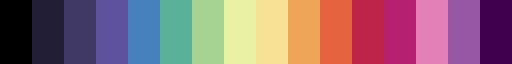

In [2]:
# Load colormap

# Read the colormap from a .txt file
def load_colormap_from_txt(file_path):
    # Load RGB values from the file
    rgb_values = np.loadtxt(file_path)
    return ListedColormap(rgb_values)

# Example usage
colormap_file = 'chase-spectral-rgb.txt'  # Replace with your .txt file path
radar_cmap = load_colormap_from_txt(colormap_file)

discrete_cmap = ListedColormap(radar_cmap(np.linspace(0, 1, 16)))
discrete_mask_cmap = discrete_cmap.copy()
discrete_mask_cmap.set_under(color='white') #set values below vmin to white
discrete_mask_cmap.set_bad(color='gray') #set missing (NaN) values to gray

discrete_mask_cmap

Define time period of case study

In [62]:
#Define time period
time_map1 = np.datetime64('2024-09-03T15:00')
time_map2 = np.datetime64('2024-09-03T16:00')

#HALO flight id
flight_id_case = 'HALO-20240903a'

Set up HALO flight segmentation stuff

In [4]:
meta = get_flight_segments()

In [5]:
# Build a list of flight segments
segments = [{**s,
             "platform_id": platform_id,
             "flight_id": flight_id
            }
            for platform_id, flights in meta.items()
            for flight_id, flight in flights.items()
            for s in flight["segments"]
           ]

flight_ids = [flight_id
              for flights in meta.values()
              for flight_id in flights]
print(f"Totel number of flights: {len(flight_ids)}")
flight_ids

Totel number of flights: 48


['HALO-20240809b',
 'HALO-20240811a',
 'HALO-20240813a',
 'HALO-20240816a',
 'HALO-20240818a',
 'HALO-20240821a',
 'HALO-20240822a',
 'HALO-20240825a',
 'HALO-20240827a',
 'HALO-20240829a',
 'HALO-20240831a',
 'HALO-20240903a',
 'HALO-20240906a',
 'HALO-20240907a',
 'HALO-20240909a',
 'HALO-20240912a',
 'HALO-20240914a',
 'HALO-20240916a',
 'HALO-20240919a',
 'HALO-20240921a',
 'HALO-20240923a',
 'HALO-20240924a',
 'HALO-20240926a',
 'HALO-20240928a',
 'HALO-20240929a',
 'ATR-20240810',
 'ATR-20240811',
 'ATR-20240813a',
 'ATR-20240813b',
 'ATR-20240815',
 'ATR-20240816a',
 'ATR-20240816b',
 'ATR-20240819',
 'ATR-20240820',
 'ATR-20240822a',
 'ATR-20240822b',
 'ATR-20240825',
 'ATR-20240826a',
 'ATR-20240826b',
 'ATR-20240827',
 'ATR-20240829',
 'ATR-20240830',
 'ATR-20240831',
 'ATR-20240901',
 'ATR-20240902',
 'ATR-20240903',
 'ATR-20240907',
 'ATR-20240910']

In [6]:
#List available segment kinds

kinds = set(k for s in segments for k in s["kinds"])

segment_ids_by_kind = {kind: [segment["segment_id"]
                              for segment in segments
                              if kind in segment["kinds"]]
                       for kind in kinds}

kinds


{' ',
 '(',
 ')',
 'A',
 'D',
 'L',
 'V',
 'a',
 'ascent',
 'atr_coordination',
 'c',
 'c_pirouette',
 'circle',
 'circle_clockwise',
 'circle_counterclockwise',
 'd',
 'descent',
 'e',
 'ec_track',
 'g',
 'i',
 'l',
 'meteor_coordination',
 'n',
 'o',
 'pace_track',
 'radar_calibration_dive',
 'radar_calibration_wiggle',
 's',
 'smart_calibration',
 'straight_leg',
 't',
 'u'}

In [7]:
# Grab all segments of a specific kind
def get_halo_position(freq="1s"):
    """Return the HALO position at a given time frequency."""
    # root = "ipns://latest.orcestra-campaign.org"
    root = "ipfs://QmSpviiAWcdFTRJu7UPkJePoEkK1XWZefx7ZjS5zuHNiFA"
    return (
        xr.open_dataset(f"{root}/products/HALO/position_attitude.zarr", engine="zarr")
        .reset_coords(("lat", "lon"))[["lat", "lon"]]
        .resample(time=freq)
        .mean()
        .load()
    )

def kinds2color(kinds):
    if "circle" and "atr_coordination" in kinds:
        return "C2"
    if "circle" and "meteor_coordination" in kinds:
        return "C4"
    if "circle" in kinds:
        return "C1"
    if "ec_track" and "meteor_coordioation" in kinds:
        return "C4"
    if "ec_track" in kinds:
        return "C3"
    if "meteor_coordination" in kinds:
        return "C4"
    return "C0"

Grab HALO Meteor coordination segments for flight on day of interest

In [8]:
ds_halo = get_halo_position()
kind = "meteor_coordination"
kind = "circle"
namee = "circle_mid"

for s in segments:
    #if kind in s["kinds"] and flight_id_case==s["flight_id"]:
    if kind in s["kinds"] and flight_id_case==s["flight_id"] and namee in s["name"]:
        t = slice(s["start"], s["end"])
        print("s", s)
        print("t", t)


s {'segment_id': 'HALO-20240903a_c30f', 'name': 'circle_mid', 'start': datetime.datetime(2024, 9, 3, 15, 2, 21), 'end': datetime.datetime(2024, 9, 3, 15, 57, 8), 'kinds': ['circle', 'circle_counterclockwise', 'meteor_coordination'], 'remarks': ['irregularity: turbulence 2024-09-03T15:17:40 - 2024-09-03T15:29:25', 'irregularity: turbulence 2024-09-03T15:46:16 - 2024-09-03T15:46:25'], 'clat': 8.501053096573967, 'clon': -30.840227080798226, 'radius': 129423.96511552358, 'platform_id': 'HALO', 'flight_id': 'HALO-20240903a'}
t slice(datetime.datetime(2024, 9, 3, 15, 2, 21), datetime.datetime(2024, 9, 3, 15, 57, 8), None)


SEA-POL reflectivity

In [63]:
#Load data
seapol = xr.open_dataset('/huracan/tank4/cornell/ORCESTRA/sea-pol/qc_data/level4v1.1/PICCOLO_level4_composite_2D_dualpol.nc')

#Find indices
index_map1 = np.abs(pd.to_datetime(seapol.time) - time_map1).argmin()
index_map2 = np.abs(pd.to_datetime(seapol.time) - time_map2).argmin()

map1 = seapol.DBZ[index_map1,:,:]
map2 = seapol.DBZ[index_map2,:,:]

In [65]:
seapol.time[index_map1:index_map2+10]

<xarray.DataArray 'time' (time: 16)> Size: 128B
array(['2024-09-03T15:00:00.000000000', '2024-09-03T15:10:00.000000000',
       '2024-09-03T15:20:00.000000000', '2024-09-03T15:30:00.000000000',
       '2024-09-03T15:40:00.000000000', '2024-09-03T15:50:00.000000000',
       '2024-09-03T16:00:00.000000000', '2024-09-03T16:10:00.000000000',
       '2024-09-03T16:20:00.000000000', '2024-09-03T16:30:00.000000000',
       '2024-09-03T16:35:00.000000000', '2024-09-03T16:40:00.000000000',
       '2024-09-03T16:50:00.000000000', '2024-09-03T17:00:00.000000000',
       '2024-09-03T17:10:00.000000000', '2024-09-03T17:20:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 128B 2024-09-03T15:00:00 ... 2024-09-03T17...
Attributes:
    standard_name:  time
    long_name:      Data time
    axis:           T
    comment:        
    cell_methods:   time: mean

In [66]:
time_map1, time_map2

(np.datetime64('2024-09-03T15:00'), np.datetime64('2024-09-03T16:00'))

In [67]:
seapol.time[index_map1], seapol.time[index_map2]

(<xarray.DataArray 'time' ()> Size: 8B
 array('2024-09-03T15:00:00.000000000', dtype='datetime64[ns]')
 Coordinates:
     time     datetime64[ns] 8B 2024-09-03T15:00:00
 Attributes:
     standard_name:  time
     long_name:      Data time
     axis:           T
     comment:        
     cell_methods:   time: mean,
 <xarray.DataArray 'time' ()> Size: 8B
 array('2024-09-03T16:00:00.000000000', dtype='datetime64[ns]')
 Coordinates:
     time     datetime64[ns] 8B 2024-09-03T16:00:00
 Attributes:
     standard_name:  time
     long_name:      Data time
     axis:           T
     comment:        
     cell_methods:   time: mean)

HALO dropsonde data

In [10]:
# root = "ipns://latest.orcestra-campaign.org"
root = "ipfs://QmSpviiAWcdFTRJu7UPkJePoEkK1XWZefx7ZjS5zuHNiFA"
drops = xr.open_dataset(f"{root}/products/HALO/dropsondes/Level_3/PERCUSION_Level_3.zarr", engine="zarr")
drops

<xarray.Dataset> Size: 85MB
Dimensions:            (altitude: 1460, sonde: 1116)
Coordinates:
  * altitude           (altitude) float64 12kB 0.0 10.0 ... 1.458e+04 1.459e+04
    launch_altitude    (sonde) float32 4kB ...
    launch_lat         (sonde) float32 4kB ...
    launch_lon         (sonde) float32 4kB ...
    launch_time        (sonde) datetime64[ns] 9kB ...
Dimensions without coordinates: sonde
Data variables: (12/23)
    bin_average_time   (sonde, altitude) datetime64[ns] 13MB ...
    flight_id          (sonde) <U14 62kB ...
    iwv                (sonde) float32 4kB ...
    lat                (sonde, altitude) float32 7MB ...
    lon                (sonde, altitude) float32 7MB ...
    p                  (sonde, altitude) float32 7MB ...
    ...                 ...
    u_qc               (sonde) int8 1kB ...
    v                  (sonde, altitude) float32 7MB ...
    v_qc               (sonde) int8 1kB ...
    vaisala_serial_id  (sonde) <U9 40kB ...
    wdir               (sonde, altitude) float32 7MB ...
    wspd               (sonde, altitude) float32 7MB ...
Attributes:
    creator_email:  helene.gloeckner@mpimet.mpg.de, theresa.mieslinger@mpimet...
    creator_name:   Helene Gloeckner, Theresa Mieslinger, Nina Robbins
    featureType:    trajectoryProfile
    history:        Level 1 ASPEN processing with Aspen V4.0.4 \nLevel 2 qual...
    keywords:       ORCESTRA, BEACH, Sounding, Dropsondes, Tropics, Atmospher...
    license:        CC-BY-4.0
    platform:       HALO
    project:        ORCESTRA, PERCUSION, MAESTRO
    references:     https://github.com/atmdrops/pydropsonde
    source:         dropsondes
    summary:        This dataset is the Level 3 BEACH dataset. It contains qu...
    title:          BEACH dropsonde dataset (Level 3)

In [11]:
# Select dropsonde from during HALO circle

# Convert to pandas for easier comparison if needed
drops_times = pd.to_datetime(drops.launch_time.values)

# Find indices within the time slice t
mask = (drops_times >= pd.to_datetime(t.start)) & (drops_times <= pd.to_datetime(t.stop))

# Select dropsondes within the time slice
drops_case = drops.isel(sonde=mask)
drops_case

<xarray.Dataset> Size: 925kB
Dimensions:            (altitude: 1460, sonde: 12)
Coordinates:
  * altitude           (altitude) float64 12kB 0.0 10.0 ... 1.458e+04 1.459e+04
    launch_altitude    (sonde) float32 48B ...
    launch_lat         (sonde) float32 48B ...
    launch_lon         (sonde) float32 48B ...
    launch_time        (sonde) datetime64[ns] 96B 2024-09-03T15:02:22 ... 202...
Dimensions without coordinates: sonde
Data variables: (12/23)
    bin_average_time   (sonde, altitude) datetime64[ns] 140kB ...
    flight_id          (sonde) <U14 672B ...
    iwv                (sonde) float32 48B ...
    lat                (sonde, altitude) float32 70kB ...
    lon                (sonde, altitude) float32 70kB ...
    p                  (sonde, altitude) float32 70kB ...
    ...                 ...
    u_qc               (sonde) int8 12B ...
    v                  (sonde, altitude) float32 70kB ...
    v_qc               (sonde) int8 12B ...
    vaisala_serial_id  (sonde) <U9 432B ...
    wdir               (sonde, altitude) float32 70kB ...
    wspd               (sonde, altitude) float32 70kB ...
Attributes:
    creator_email:  helene.gloeckner@mpimet.mpg.de, theresa.mieslinger@mpimet...
    creator_name:   Helene Gloeckner, Theresa Mieslinger, Nina Robbins
    featureType:    trajectoryProfile
    history:        Level 1 ASPEN processing with Aspen V4.0.4 \nLevel 2 qual...
    keywords:       ORCESTRA, BEACH, Sounding, Dropsondes, Tropics, Atmospher...
    license:        CC-BY-4.0
    platform:       HALO
    project:        ORCESTRA, PERCUSION, MAESTRO
    references:     https://github.com/atmdrops/pydropsonde
    source:         dropsondes
    summary:        This dataset is the Level 3 BEACH dataset. It contains qu...
    title:          BEACH dropsonde dataset (Level 3)

Make plot

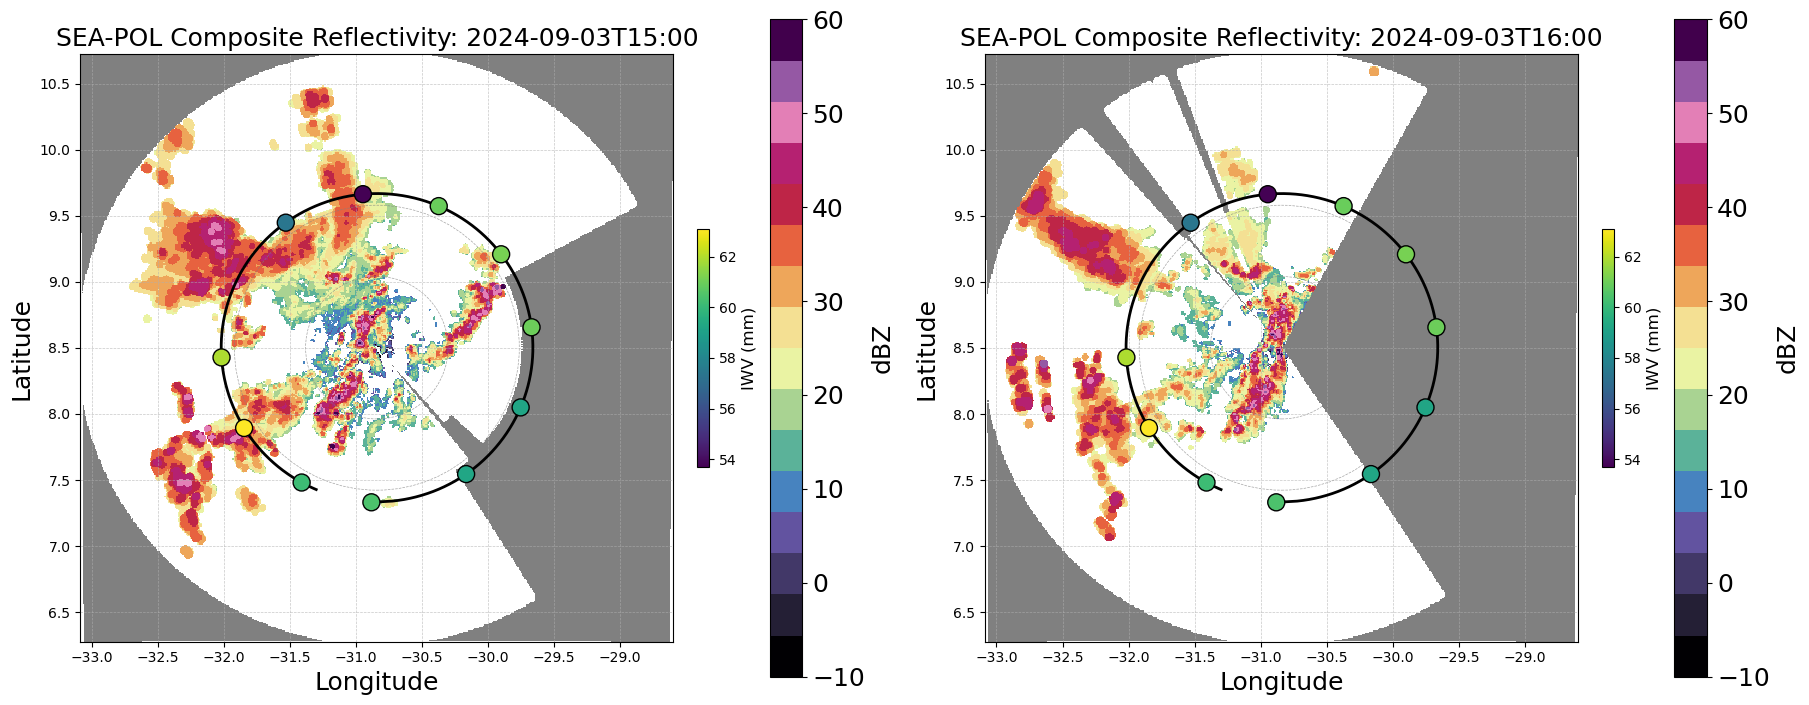

In [68]:
# Make plot
fig, axs = plt.subplots(1,2, figsize=(18, 8),layout="constrained")  # 1 row, 2 column

cax = axs[0].pcolormesh(map1.longitude, map1.latitude, map1, cmap=discrete_mask_cmap, vmin=-10, vmax=60,shading='auto')
axs[0].set_aspect('equal',adjustable='box')
cbar = fig.colorbar(cax, ax=axs[0], orientation='vertical',pad=0.02, shrink=0.83)
cbar.ax.tick_params(labelsize=18)
cbar.set_ticks(np.linspace(-10,60,8))
cbar.ax.set_ylabel('dBZ', fontsize=18)

# plot HALO circle
axs[0].plot(ds_halo.lon.sel(time=t), ds_halo.lat.sel(time=t), c='black', linewidth=2,zorder=2)

# plot HALO dropsondes
sc = axs[0].scatter(drops_case.launch_lon, drops_case.launch_lat, c=drops_case.iwv, cmap='viridis', s=150, edgecolors='k',zorder=3)
cbar2 = plt.colorbar(sc, ax=axs[0], orientation='vertical', fraction=0.02, pad=0.04)
cbar2.ax.set_ylabel('IWV (mm)', fontsize=12)

axs[0].set_title('SEA-POL Composite Reflectivity: ' + str(time_map1),fontsize=18)    
axs[0].set_ylabel('Latitude', fontsize=18)
axs[0].set_xlabel('Longitude',fontsize=18)
#axs[0].set_xticks(np.linspace(-40,-36, 5))  # Adjust the number of ticks as needed
#axs[0].set_yticks(np.linspace(12, 16, 5))  # Adjust the number of ticks as needed
#axs[0].set_xticklabels(axs[0].get_xticklabels(), fontsize=18)
#axs[0].set_yticklabels(axs[0].get_yticklabels(), fontsize=18)

cax = axs[1].pcolormesh(map2.longitude, map2.latitude, map2, cmap=discrete_mask_cmap, vmin=-10, vmax=60,shading='auto')
axs[1].set_aspect('equal',adjustable='box')

cbar = fig.colorbar(cax, ax=axs[1], orientation='vertical',pad=0.02, shrink=0.83)
cbar.ax.tick_params(labelsize=18)
cbar.set_ticks(np.linspace(-10,60,8))
cbar.ax.set_ylabel('dBZ', fontsize=18)

# plot HALO circle
axs[1].plot(ds_halo.lon.sel(time=t), ds_halo.lat.sel(time=t), c='black', linewidth=2,zorder=2)

# plot HALO dropsondes
sc = axs[1].scatter(drops_case.launch_lon, drops_case.launch_lat, c=drops_case.iwv, cmap='viridis', s=150, edgecolors='k',zorder=3)
cbar2 = plt.colorbar(sc, ax=axs[1], orientation='vertical', fraction=0.02, pad=0.04)
cbar2.ax.set_ylabel('IWV (mm)', fontsize=12)

axs[1].set_title('SEA-POL Composite Reflectivity: ' + str(time_map2),fontsize=18)    
axs[1].set_ylabel('Latitude', fontsize=18)
axs[1].set_xlabel('Longitude',fontsize=18)
#axs[1].set_xticks(np.linspace(-40,-36, 5))  # Adjust the number of ticks as needed
#axs[1].set_yticks(np.linspace(12, 16, 5))  # Adjust the number of ticks as needed
#axs[1].set_xticklabels(axs[0].get_xticklabels(), fontsize=18)
#axs[1].set_yticklabels(axs[0].get_yticklabels(), fontsize=18)

# Add grid lines to the first subplot
axs[0].grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# Add grid lines to the second subplot
axs[1].grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# Add 120 km circle
axs[0].add_patch(plt.Circle((map1.longitude[245,245], map1.latitude[245,245]), 120/111.32, color='gray', alpha = 0.7,fill=False, linestyle='--', linewidth=0.5))
axs[1].add_patch(plt.Circle((map2.longitude[245,245], map2.latitude[245,245]), 120/111.32, color='gray', alpha = 0.7,fill=False, linestyle='--', linewidth=0.5))

# Add 60 km circle
axs[0].add_patch(plt.Circle((map1.longitude[245,245], map1.latitude[245,245]), 60/111.32, color='gray', alpha = 0.7,fill=False, linestyle='--', linewidth=0.5))
axs[1].add_patch(plt.Circle((map2.longitude[245,245], map2.latitude[245,245]), 60/111.32, color='gray', alpha = 0.7,fill=False, linestyle='--', linewidth=0.5))